<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/main/notebooks/ModuleXX_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning and Neural Networks with Phishing Email Data

Neural networks are a subset of machine learning algorithms inspired by the human brain's structure and function. They consist of layers of interconnected "neurons" that transform the input data through weighted connections to produce an output. Neural networks are particularly powerful for complex tasks like image recognition and natural language processing.

Neural networks consist of an input layer, one or more hidden layers, and an output layer. These layers consist of "neurons" where each neuron processes input data by applying a weight and an activation function (like sigmoid or ReLU) to produce an output. The training (or learning) process adjusts the weights of the connections between neurons using algorithms like backpropagation and optimization techniques like gradient descent. Neural networks, particularly deep neural networks (deep learning), can model highly complex relationships between inputs and outputs by learning hierarchical feature representations in the hidden layers. Deep learning neural networks typically contain three or more hidden layers.

<center><img src="https://images.edrawsoft.com/articles/neural-network-diagram/example1.png" width="800" height="600"></center>




In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import datetime
import os 
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

2024-11-13 07:15:16.618695: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 07:15:16.768856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 07:15:16.828276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 07:15:16.844905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 07:15:16.943510: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Supress debug warnings in training output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages
tf.get_logger().setLevel('ERROR')

In [3]:
# Set random seed static value for consistent results
seed = 42

In [4]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15980582077031406625
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9963569152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17891662601761916482
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1731500118.665232     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500118.778398     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500118.778443     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500118.919781     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500118.919870     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-13

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

## Dataset

The dataset that will be used to train and test the different models was from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It was pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.

In [6]:
# Read in the data into a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/Datasets/refs/heads/main/Kaggle/Phishing_Email.csv.gz')
#df = pd.read_csv('../datasets/Phishing_Email.csv')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [7]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [8]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [9]:
# Show the shape of the data
df.shape

(17538, 2)

In [10]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [11]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

Email Type
Safe Email        10980
Phishing Email     6558
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

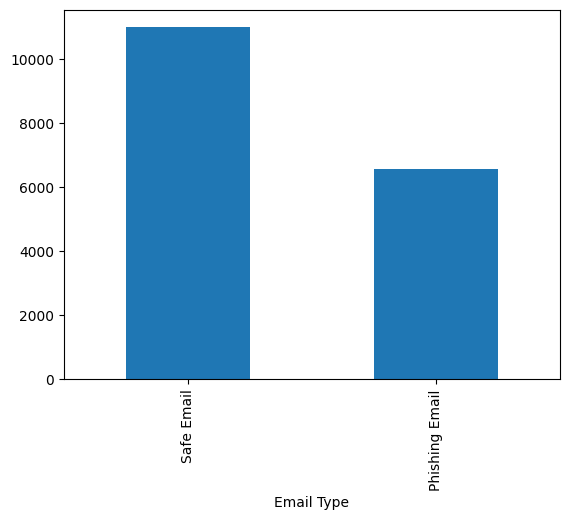

In [12]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [13]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [14]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [15]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1


## Simple Neural Network

The [`SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layer in TensorFlow is a [recurrent neural network (RNN)]9https://en.wikipedia.org/wiki/Recurrent_neural_network) layer that processes sequential data, making it suitable for tasks like time series prediction or text generation. Each unit in SimpleRNN maintains a hidden state across time steps, allowing the model to "remember" previous inputs in the sequence. It supports configurations for returning only the final output or the entire sequence, and can also be stacked with other layers for deeper architectures. This layer is simpler and faster than more complex RNN types, like LSTM or GRU, but may struggle with longer sequences.

Because our email messages are variable length, we need to fix the length of each vector we create. In deep learning, it’s often beneficial to have inputs of consistent shapes. Setting max_len ensures that all sequences are padded or truncated to a specific length, allowing you to batch-process sequences more efficiently. 


In [16]:
#Set max_len
max_len = 256

We initalize a new [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class which is used for preprocessing text data by converting words or characters into numerical representations that a machine learning model can understand. In general, a token is a word or a character.  In our case, a token is a word.

In [17]:
#Initialize new instance of Tokenizer class.
tk = Tokenizer()

The next step is to use `fit_on_texts` method in the 'Tokenizer' class to  processes each text entry in the `Email Text` column of the Pandas data frame to build a vocabulary, where each unique word (or token) is assigned a unique integer index based on its frequency across the entire dataset. It then creates a word index mapping each word (token) to a unique integer in each email. 

Then we use the `texts_to_sequences` method to create a list of integer sequence for each email from our word index mappings.  These sequence of integers are then converted to vectors of fixed length (256 from our max_len variable) and padded or truncated as necessary and stored in a numpy array.


In [18]:
# Process the text
tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [19]:
#Number of rows in the vector numpy array, matches the number of emails in our dataset.
vector.shape[0]

17538

In [20]:
#Length of our word index
len(tk.word_index) + 1

182317

Now we set the `max_features` parameter to limit our overall vocabulary size to the most frequent words. There are two main reasons for this:

- Reduces Memory Usage: In many NLP tasks, datasets contain thousands or millions of unique words. Limiting the vocabulary size to the most frequent words helps reduce memory and computational requirements, which is especially helpful when working with limited resources or large datasets.
- Improves Model Generalization: High vocabulary sizes can lead to overfitting, as the model might memorize rare words that do not generalize well to new data. Setting max_features forces the model to focus on the most important and commonly occurring words, which generally improves performance on unseen data

In [21]:
max_features=10000

Now we split our dataset into training and testing sets using the `train_test_split function` from scikit-learn.  We will train our neural network on 80 percent of the data, then evaluate the accuracy on the remaining 20 percent. 

In [22]:
x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

Next we define a simple neural network model using TensorFlow’s Keras Sequential API which is specifically designed for text data and allows you to stack layers in a linear sequence. Each added layer will be executed in the order it’s added, from the first layer to the last. 

The first line of code in the next block defines the Sequential model then we add the Embedding layer, This is the first layer in the model, used to convert input words (represented as integer indices) into dense vectors of fixed size.
len(tk.word_index)+1 is the size of the vocabulary, where tk.word_index is the dictionary of words created by the Tokenizer. Adding 1 ensures that there’s an index for each word plus one additional index, often reserved for unknown or padding tokens.
50 is the dimensionality of the word embeddings, meaning each word in the vocabulary will be represented by a 50-dimensional vector. This vector captures semantic relationships between words.

In [23]:
model_srnn = Sequential() # Sequential() API
model_srnn.add(Embedding(len(tk.word_index)+1,50))
model_srnn.add(SimpleRNN(units=100))
model_srnn.add(Dropout(0.5))
model_srnn .add(Dense(1, activation='sigmoid'))

I0000 00:00:1731500124.640958     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500124.641065     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500124.641086     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500124.641428     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731500124.641465     567 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [24]:
model_srnn.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [25]:
historical_srnn  = model_srnn.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20


I0000 00:00:1731500125.681398     678 service.cc:146] XLA service 0x7f3244007e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731500125.681431     678 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-11-13 07:15:25.717409: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 07:15:25.856776: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  5/877 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.4433 - loss: 0.7152

I0000 00:00:1731500126.424970     678 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


877/877 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.5513 - loss: 0.7111 - val_accuracy: 0.6166 - val_loss: 0.6779
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 30s 35ms/step - accuracy: 0.6057 - loss: 0.6723 - val_accuracy: 0.6237 - val_loss: 0.6562
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6224 - loss: 0.6521 - val_accuracy: 0.6380 - val_loss: 0.6402
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.6563 - loss: 0.6153 - val_accuracy: 0.6471 - val_loss: 0.6267
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.6763 - loss: 0.5836 - val_accuracy: 0.5507 - val_loss: 0.6342
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6762 - loss: 0.5727 - val_accuracy: 0.6619 - val_loss: 0.6425
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6918 - loss: 0.5519 - val_accuracy: 0.6705 - val_loss: 0.5991
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 31s 35ms/step - accuracy: 0.6947 - loss: 0.5475 - val_accurac

Text(0, 0.5, 'Loss')

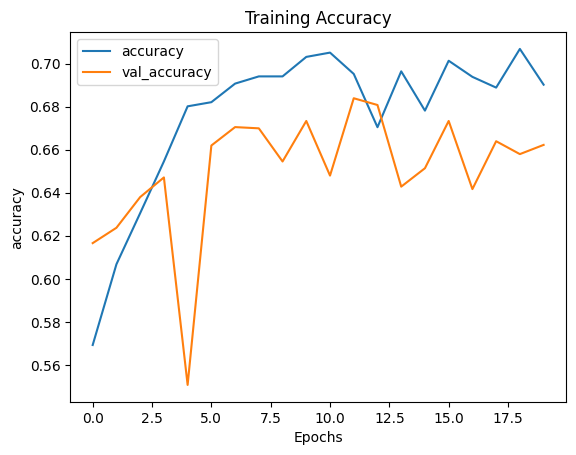

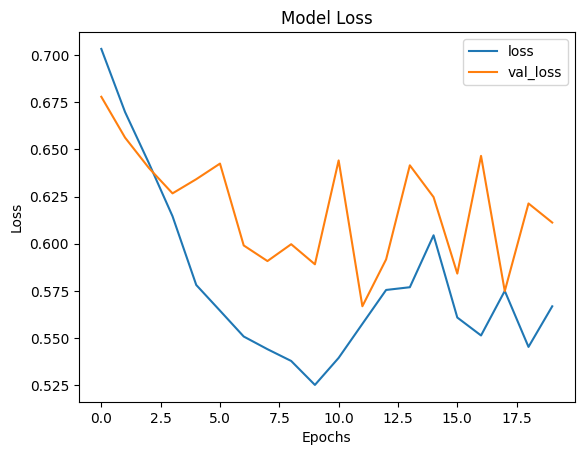

In [26]:

pd.DataFrame(historical_srnn.history)

pd.DataFrame(historical_srnn.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_srnn.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


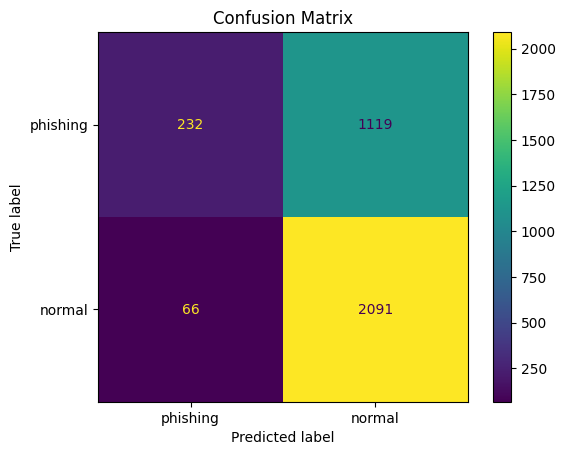

In [27]:
y_pred_prob_smp = model_srnn.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)


cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['phishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Evaluate the model on the test set
srnn_loss, srnn_accu = model_srnn.evaluate(x_test, y_test, verbose=0)

srnn_accu = (srnn_accu*100)

# Display the accuracy value
print(f'The accuracy of the SRNN model on the test data set was: {srnn_accu:.4f}')

The accuracy of the SRNN model on the test data set was: 66.2201


## LTSM

In [29]:
model_lstm = Sequential() # Sequential() API
model_lstm.add(Embedding(len(tk.word_index)+1,50))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

In [30]:
model_lstm.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [31]:
historical_lstm  = model_lstm.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.6468 - loss: 0.6370 - val_accuracy: 0.6397 - val_loss: 0.6382
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6830 - loss: 0.5748 - val_accuracy: 0.6787 - val_loss: 0.5848
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7709 - loss: 0.4422 - val_accuracy: 0.9168 - val_loss: 0.2735
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9368 - loss: 0.2279 - val_accuracy: 0.9156 - val_loss: 0.2639
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9495 - loss: 0.1786 - val_accuracy: 0.9601 - val_loss: 0.1254
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9604 - loss: 0.1195 - val_accuracy: 0.9655 - val_loss: 0.1035
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9868 - loss: 0.0463 - val_accuracy: 0.9672 - val_loss: 0.1195
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9945 - loss: 0.0248 - 

In [32]:
lstm_results = model_lstm.evaluate(x_test, y_test)
lstm_loss = lstm_results[0]  # Extract the loss from the results
lstm_accu = (lstm_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {lstm_loss}")
print(f"Model Accuracy: {lstm_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9781 - loss: 0.1067
Model Loss: 0.10340185463428497
Model Accuracy: 98.00456166267395


In [33]:
y_pred_prob = model_lstm.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Text(0, 0.5, 'Loss')

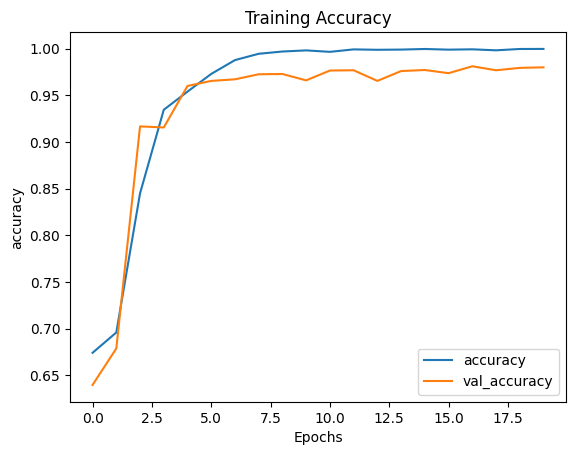

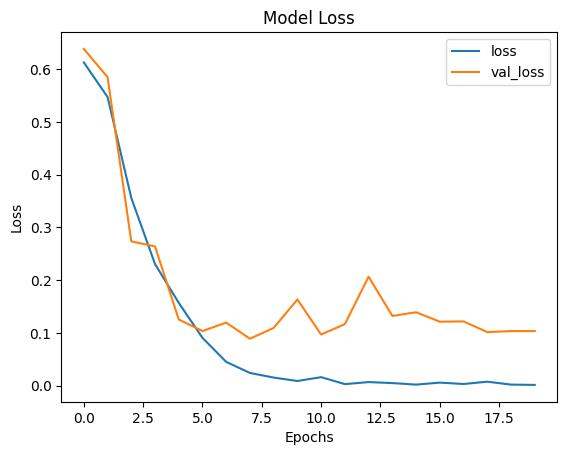

In [34]:
pd.DataFrame(historical_lstm.history)

pd.DataFrame(historical_lstm.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_lstm.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

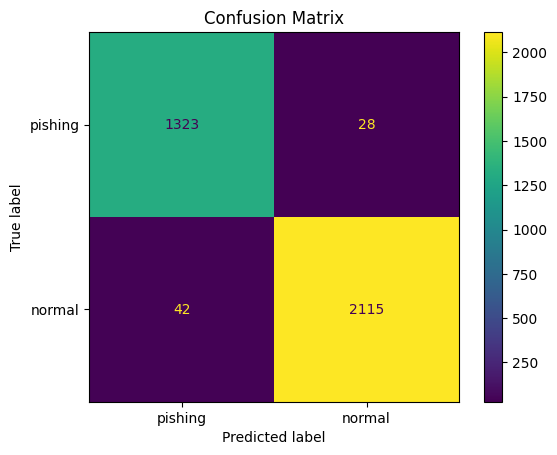

In [35]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['pishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

## Bidirectional

In [36]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(len(tk.word_index)+1,50))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [37]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [38]:
historical_bi  = model_bi.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.8494 - loss: 0.3200 - val_accuracy: 0.9761 - val_loss: 0.0757
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.9815 - loss: 0.0547 - val_accuracy: 0.9803 - val_loss: 0.0633
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.9965 - loss: 0.0137 - val_accuracy: 0.9715 - val_loss: 0.0749
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9970 - loss: 0.0112 - val_accuracy: 0.9800 - val_loss: 0.0815
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.9990 - loss: 0.0065 - val_accuracy: 0.9781 - val_loss: 0.0932
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9686 - val_loss: 0.1693
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.9963 - loss: 0.0150 - val_accuracy: 0.9481 - val_loss: 0.1740
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9977 - loss: 0.0074 - 

In [39]:
bi_results = model_bi.evaluate(x_test, y_test)
bi_loss = bi_results[0]  # Extract the loss from the results
bi_accu = (bi_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {bi_loss}")
print(f"Model Accuracy: {bi_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9789 - loss: 0.1389
Model Loss: 0.13877131044864655
Model Accuracy: 97.69099354743958


In [40]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Text(0, 0.5, 'Loss')

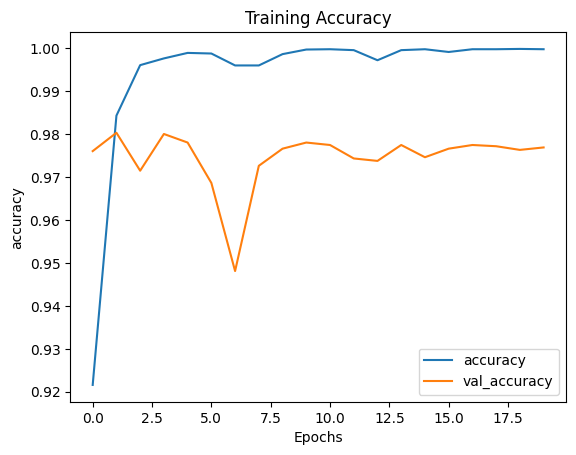

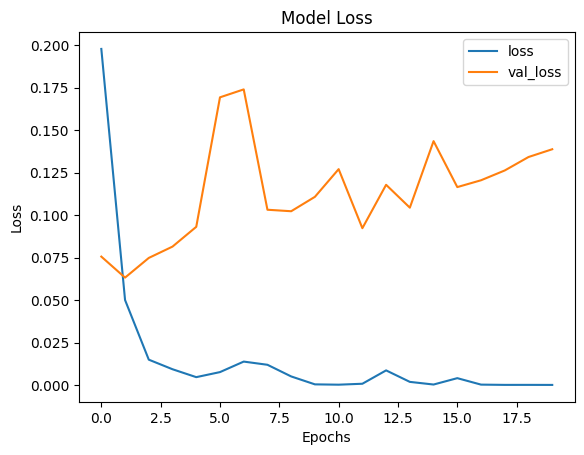

In [41]:
pd.DataFrame(historical_bi.history)

pd.DataFrame(historical_bi.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_bi.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

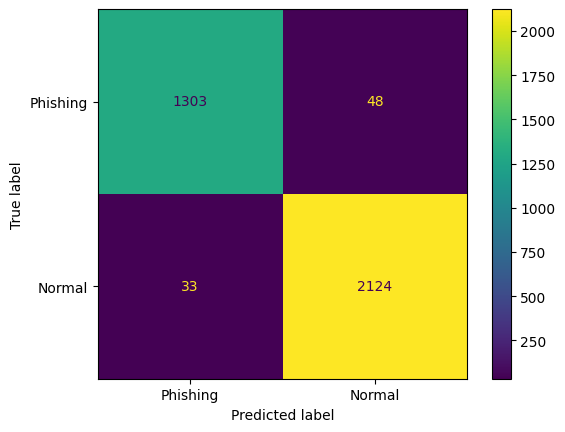

In [42]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Phishing','Normal'])
ax_bi.plot()
plt.show()

### Gated Recurrent Unit

In [43]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(len(tk.word_index)+1,50))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [44]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [45]:
historical_gru = model_gru.fit(x_train,y_train, epochs=20, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.6394 - loss: 0.6410 - val_accuracy: 0.8694 - val_loss: 0.3898
Epoch 2/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.8658 - loss: 0.3443 - val_accuracy: 0.9148 - val_loss: 0.2561
Epoch 3/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.9039 - loss: 0.2604 - val_accuracy: 0.9404 - val_loss: 0.1988
Epoch 4/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9620 - loss: 0.1139 - val_accuracy: 0.9672 - val_loss: 0.0973
Epoch 5/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.9911 - loss: 0.0366 - val_accuracy: 0.9766 - val_loss: 0.0760
Epoch 6/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9972 - loss: 0.0129 - val_accuracy: 0.9749 - val_loss: 0.0897
Epoch 7/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.9979 - loss: 0.0102 - val_accuracy: 0.9726 - val_loss: 0.1118
Epoch 8/20
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9986 - loss: 0.0063 - 

In [46]:
gru_results = model_gru.evaluate(x_test, y_test)
gru_loss = gru_results[0]  # Extract the loss from the results
gru_accu = (gru_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {gru_loss}")
print(f"Model Accuracy: {gru_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9770 - loss: 0.1399
Model Loss: 0.1262418031692505
Model Accuracy: 97.86202907562256


In [47]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Text(0, 0.5, 'Loss')

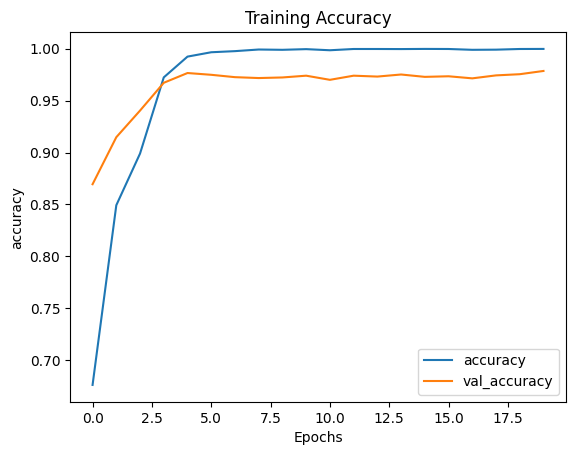

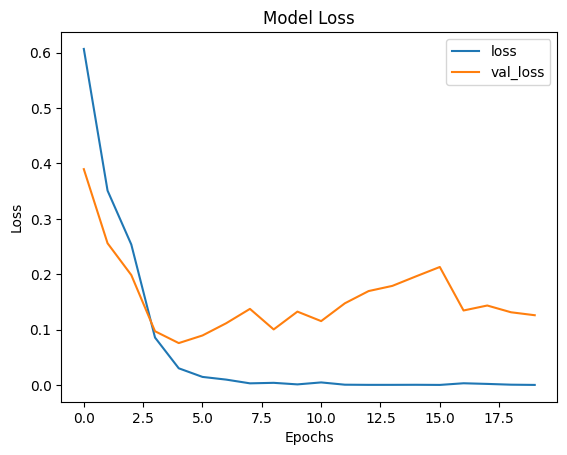

In [48]:
pd.DataFrame(historical_gru.history)

pd.DataFrame(historical_gru.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_gru.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

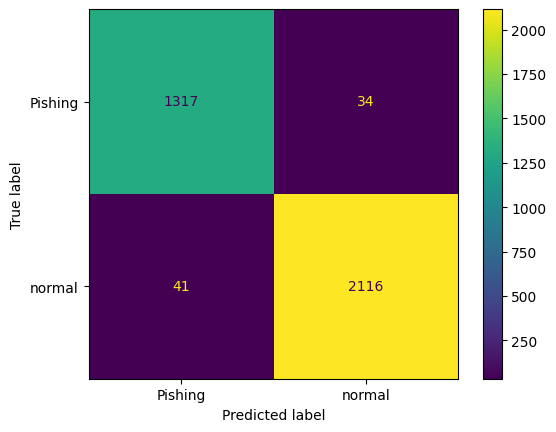

In [49]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['Pishing','normal'])
ax_gru.plot()
plt.show()

# Model Comparisons

In [50]:
# Need to do - set up table of models and comparisons

accu_values = [srnn_accu,lstm_accu, bi_accu, gru_accu]
row_labels = ["Simple RNN", "LSTM Neural Network", "Bidirectional Neural Network", "Gated Recurrent Unit"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                               accuracy
Simple RNN                    66.220069
LSTM Neural Network           98.004562
Bidirectional Neural Network  97.690994
Gated Recurrent Unit          97.862029
